# Compressed GPU Textures

GPUs cannot sample a texel from conventional compressed images like JPEG, PNG and WEBP because the entire image must be decoded before a pixel value can be determined. The naive approach of using textures in the GPU is to decompress images in the CPU, then upload the entire decompressed texture data to the GPU. Modern applications, however, use hundreds of textures, and each of them can get very large. Textures resolution of 2048x2048 is common for objects meant to be looked at up close in modern games, and a dozen color channels may be needed to represent its material properties such as base color, normal map, roughness, metallic, emissive and so on. With 8-bit color depth per channel, this would require ~50 MB of texture data per object. Working with with hundreds of uncompressed textures is infeasible for most users with 4-8 GB of GPU memory.

Many compressed texture formats that can be consumed by the GPU were developed to combat this issue. Compressed GPU textures has benefits aside from space saving. For one, compressed textures often deliver better performance as a result of improved data locality. Second, it reduces applications' load times as it does not need to be decompressed on the CPU and less data need to be uploaded to the GPU. Use of compressed GPU textures are recommended for graphics applications for these reasons.

ASTC is currently the state of the art compressed GPU texture format. In this format, the image is broken up into default block size of 4x4 to a maximum of 12x12, and each block is compressed separately into fixed size of 128-bits. It leverages the fact that little color variation is expected in a small image block, and colors tend to be correlated. The 128-bit blocks store color endpoints and interpolation index between the endpoints for each pixel of the block. When a GPU samples a texel, only the 128-bit data block containing the texel needs to be decoded.

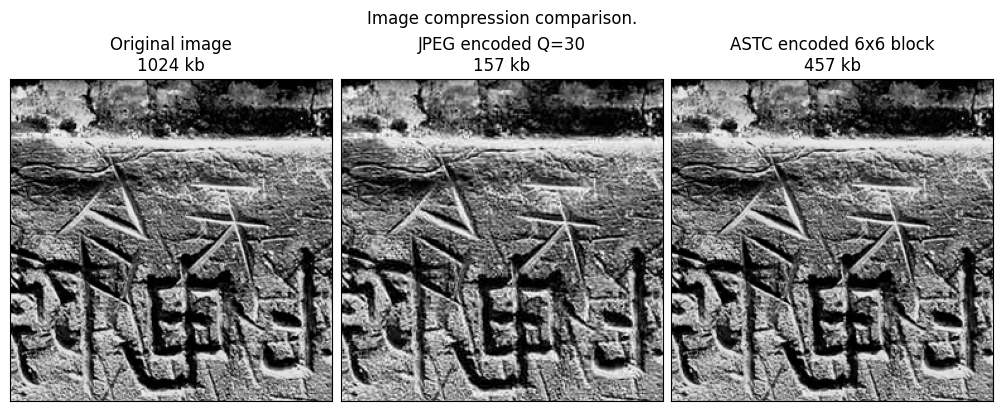

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

image = cv.imread('images/brick.png', cv.IMREAD_GRAYSCALE)
image_size = image.size
image_dimension = image.shape

jpeg_quality = 30
jpeg_encoded = cv.imencode('.jpeg', image, params=[cv.IMWRITE_JPEG_QUALITY, jpeg_quality])[1]
jpeg_decoded = cv.imdecode(jpeg_encoded, cv.IMREAD_GRAYSCALE)
jpeg_size = jpeg_encoded.size

astc_decoded = cv.imread('images/brick_astc6x6.png', cv.IMREAD_GRAYSCALE)
astc_size = 467872

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), layout='compressed')
fig.suptitle('Image compression comparison.')

axes[0].set_title("Original image\n{size:.0f} kb".format(size=image_size/1024))
axes[0].tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
axes[0].imshow(image, cmap='gray')
axes[0].set_xlim(256, 512)
axes[0].set_ylim(512, 256)

axes[1].set_title("JPEG encoded Q={quality}\n{size:.0f} kb".format(quality=jpeg_quality, size=jpeg_size/1024))
axes[1].tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
axes[1].imshow(jpeg_decoded, cmap='gray')
axes[1].set_xlim(256, 512)
axes[1].set_ylim(512, 256)

axes[2].set_title("ASTC encoded 6x6 block\n{size:.0f} kb".format(size=astc_size/1024))
axes[2].tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
axes[2].imshow(astc_decoded, cmap='gray')
axes[2].set_xlim(256, 512)
axes[2].set_ylim(512, 256)

plt.show()

# Goals
In this project, I want to come up with an texture compression scheme with the following requirements:
1. GPU should be able to sample a texel on the fly.
2. Acceptable visual quality.
3. 4:1 compression ratio.

# Plan
1. Each channel of the image is divided into 4x4 blocks. These 4\*4\*8-bit = 128-bit blocks should be compressed into 32-bits for 4:1 ratio.
2. Run a discrete cosine transform on these 4x4 texture block to to get coefficients for each cosine frequency basis. Coefficients for high frequency bases are ignored.
3. Using machine learning methods, learn the best quantization table for these coefficients.



In [305]:
# Encode each block_size x block_size region separately.
block_size = 4

In [416]:
# Precompute DCT-II transformation matrix
dct_transform_matrix = np.empty((block_size, block_size))
for i in range(block_size):
    dct_transform_matrix[0, i] = 1.0 / np.sqrt(block_size)
for i in range(block_size):
    for j in range(1, block_size):
        dct_transform_matrix[j, i] = np.sqrt(2.0/block_size) * np.cos((2.0*i+1.0)*j*np.pi/(2.0*block_size))
dct_transform_matrix_inverse = dct_transform_matrix.transpose()

def dct_transform(image_block):
    return np.matmul(np.matmul(dct_transform_matrix, image_block - 128), dct_transform_matrix_inverse)
    
def inverse_dct_transform(coefficient_block):
    return np.matmul(np.matmul(dct_transform_matrix_inverse, coefficient_block), dct_transform_matrix) + 128

In [417]:
# Precompute mask matrices for diagonal culling.
cull_masks = np.zeros((2*block_size, block_size, block_size))
for i in range(block_size):
    for j in range(block_size):
        for k in range(2*block_size-i-j-1):
            cull_masks[k, j, i] = 1
            
# Remove 'n' diagonals from the DCT-coefficient block starting from bottom-right.
def cull_diagonals(coefficient_block, n):
    return np.multiply(coefficient_block, cull_masks[n])

In [429]:
# Image has to be padded if either width or height is not multiple of 'block_size'.
horizontal_blocks = int(np.ceil(image_dimension[1]/block_size))
vertical_blocks = int(np.ceil(image_dimension[0]/block_size))
horizontal_padding = int(horizontal_blocks*block_size - image_dimension[1])
vertical_padding = int(vertical_blocks*block_size - image_dimension[0])
image_padded = np.pad(image, ((0, vertical_padding), (0, horizontal_padding)))

# Rearrange image into block_size * block_size matrices.
image_blocks = image_signed.reshape((vertical_blocks, block_size, horizontal_blocks, block_size)).swapaxes(1, 2)

# Decompose image blocks into coefficients of DCT frequency bases.
dct_coefficient_blocks = dct_transform(image_blocks)

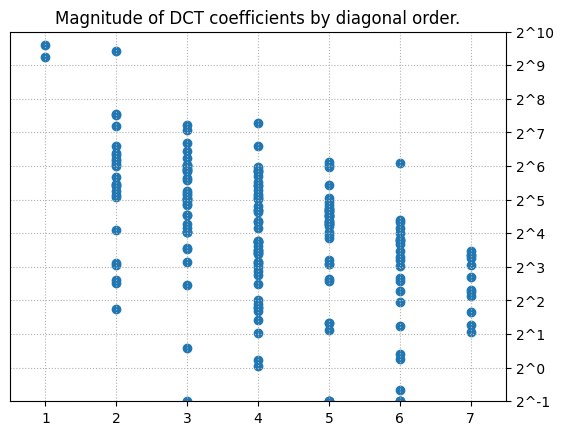

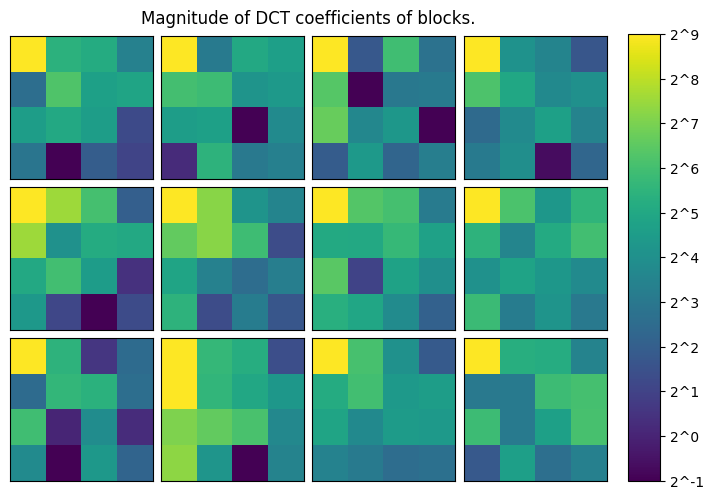

In [430]:
# This code block is for numerical analysis of estimating the number of bits needed to encode the DCT-coefficients

# Take N random blocks and log-scale the DCT-coefficients
sample_count = 12
sample_indices = np.divmod(np.random.choice(horizontal_blocks*vertical_blocks, sample_count), horizontal_blocks)
sample_blocks = dct_coefficient_blocks[sample_indices]
log_coefficients = np.log2(np.clip(2.0*np.abs(sample_blocks), a_min=0.5, a_max=None))

# Plot DCT-coefficients on each diagonal rank.
plot_points = np.empty((2, sample_count*block_size*block_size))
point_index = 0
for rank in range(1, 2*block_size):
    for row_index in range(max(rank-block_size, 0), min(rank, block_size)):
        for sample_index in range(sample_count):
            plot_points[0, point_index] = rank
            plot_points[1, point_index] = log_coefficients[sample_index, row_index, rank-row_index-1]
            point_index += 1
axes = plt.axes(title='Magnitude of DCT coefficients by diagonal order.', 
                xlim=(0.5, 2.0*block_size-0.5),
                ylim=(-1.0, 10.0))
axes.set_yticks(np.arange(start=-1, stop=11, step=1, dtype=int))
axes.yaxis.tick_right()
axes.yaxis.set_major_formatter('2^{x}')
axes.scatter(plot_points[0, :], plot_points[1, :])
plt.grid(linestyle=':')
plt.show()

# Heat map of the sampled coefficient blocks
nrows = np.sqrt(sample_count).astype(int)
ncols = np.ceil(sample_count/nrows).astype(int)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, layout='compressed')
for i, ax in zip(range(sample_count), axes.flat):
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False)
    heatmap = ax.imshow(log_coefficients[i], vmin=-1, vmax=9)
cbar_ax = fig.add_axes([1.00, 0.01, 0.05, 0.93])
cbar = fig.colorbar(mappable=heatmap, cax=cbar_ax, format="2^{x:.0f}")
cbar.set_ticks(np.linspace(-1., 9., num=11, endpoint=True))
fig.suptitle('Magnitude of DCT coefficients of blocks.')
plt.show()

Reconstructing the image from all coefficients result in an identical image from the original.

Reconstructing the image from 10 out of 16 coefficients result in an acceptable image degredation.

Reconstructing the image from 6 out of 16 coefficients result in a very blurry image.

Based on this empirical analysis I decided to only store 10 coefficients.

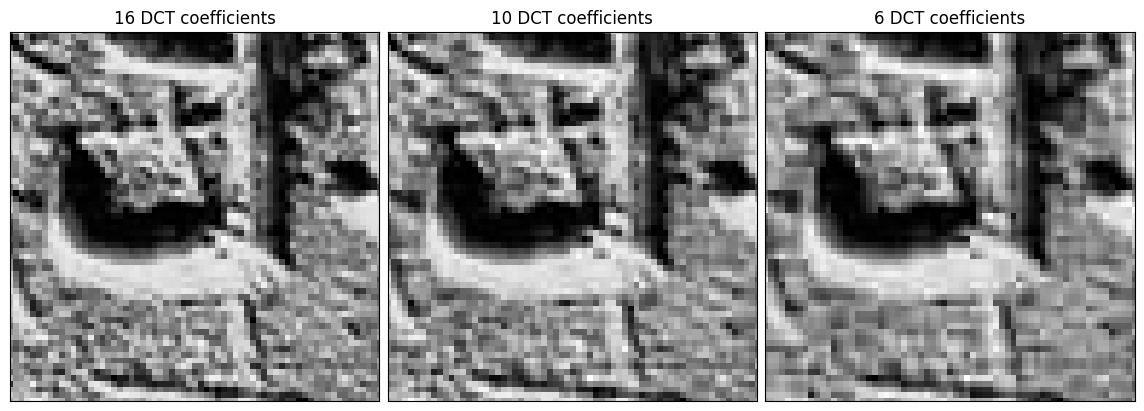

In [431]:
reconstructed = np.empty((3,) + image_padded.shape)
for i, n in enumerate([0, 3, 4]):
    reconstructed_blocks = np.empty(image_blocks.shape)
    for j in range(horizontal_blocks):
        for k in range(vertical_blocks):
            reconstructed_blocks[k, j] = inverse_dct_transform(cull_diagonals(dct_coefficient_blocks[k, j], n))
    reconstructed[i] = reconstructed_blocks.swapaxes(1, 2).reshape(image_padded.shape).astype(int) + 128

fig, axes = plt.subplots(ncols=3, figsize=(12, 4), layout='compressed')
for ax, im, title in zip(axes.flat, 
                         reconstructed, 
                         ['16 DCT coefficients', '10 DCT coefficients', '6 DCT coefficients']):
    ax.set_title(title)
    ax.set_xlim(448, 512)
    ax.set_ylim(512, 448)
    ax.tick_params(left=False, right=False, top=False, bottom=False, labelleft=False, labelbottom=False) 
    im = ax.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.show()

In [432]:
# parameters:
#     X: input data of size samples x features
#     K: number of clusters
# returns:
#     separated: list of input data separated as clusters
#     centroids: mean value of each cluster
def k_means(X, K, iterations, tolerance=1e-7):
    Xs = X.reshape(X.shape[0], -1)
    
    # N samples and d features.
    N, d = Xs.shape
    
    # Random initialization of centroids.
    data_mean = np.mean(Xs, axis=0)[:,np.newaxis]
    centroids = 16.0*np.random.randn(d, K) + data_mean
    # cluster assignments using 1-hot representation
    ph = np.zeros((K,N))
    # distance from each cluster center to each point
    last_objective = np.finfo('d').max
    
    for _ in range(iterations):
        centroids_sq = np.asmatrix(np.sum(centroids**2.0, axis=0)).transpose()
        centroids_Xs = np.dot(centroids.transpose(), Xs.transpose())
        Xs_sq = np.sum(Xs**2.0, axis=1)
        distance = centroids_sq - 2.0*centroids_Xs + Xs_sq
        
        # objective is sum of distances from each sample
        # to its closest cluster
        objective = np.sum(np.min(distance,axis=0))
        
        # find closest clusters all at once
        labels = np.argmin(distance,axis=0).transpose()

        # convert the closest cluster id to one-hot
        # representation
        ph[:] = 0
        for (i,v) in enumerate(labels):
            ph[v, i] = 1.0
            
        if last_objective - objective < tolerance:
            break
        else:           
            last_objective = objective

        centroids = np.dot(Xs.transpose(), ph.transpose())/(1e-5 + np.sum(ph,axis=1))

    # separate X by assigned labels
    # indices := array of indices that would result in labels being sorted
    # counts := each label's number of occurence
    _, indices, counts = np.unique(np.asarray(labels), return_counts=True, return_inverse=True)
    separated = np.split(X[indices.argsort()], counts.cumsum()[:-1])
    
    return separated, centroids.transpose().reshape((K,) + X[0].shape)

In [433]:
def generate_quantization_tables(image_blocks):
    # Perform DCT transformation
    coefficient_blocks = dct_transform(image_blocks)
    # Try to group similar data into 4 clusters
    clustered_data, cluster_means = k_means(coefficient_blocks, 4, 100)
    quantization_table = np.zeros((4, block_size, block_size, 8))
    for i in range(4):
        for y in range(block_size):
            for x in range(block_size - y):
                _, coefficient_means = k_means(clustered_data[i][:, y, x], 8, 20)
                quantization_table[i, y, x] = coefficient_means
    return quantization_table, cluster_means

quantization_table, cluster_means = generate_quantization_tables(dct_coefficient_blocks.reshape(65536, 4, 4)[0:256,:])

In [444]:
def quantize_coefficients(coefficient_block):
    # Choose quantization table associated with closest cluster mean
    table_index = np.argmin(np.sum(np.square(np.subtract(cluster_means, coefficient_block)), axis=(1, 2)))
    # Choose quantized value that yields smallest squared error
    quantized_coefficients = np.argmin(np.square(np.subtract(quantization_table[table_index].transpose(2, 0, 1), coefficient_block)), axis=0)
    return table_index, quantized_coefficients

def encode_image_block(image_block):
    table_index, coefficients = quantize_coefficients(dct_transform(image_block))
    encoded = np.empty(11, dtype='int')
    encoded[0] = table_index
    for k, (j, i) in enumerate([(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0)]):
        encoded[k+1] = coefficients[j, i]
    return encoded

def encode_image(image):
    height, width = image.shape
    horizontal_blocks = int(np.ceil(width / block_size))
    vertical_blocks = int(np.ceil(height / block_size))
    horizontal_padding = int(horizontal_blocks * block_size - width)
    vertical_padding = int(vertical_blocks * block_size - height)
    image_padded = np.pad(image, ((0, vertical_padding), (0, horizontal_padding)))
    image_blocks = image_padded.reshape((vertical_blocks, block_size, horizontal_blocks, block_size)).swapaxes(1, 2)
    encoded_blocks = np.empty((vertical_blocks, horizontal_blocks, 11), dtype='int')
    for i in range(horizontal_blocks):
        for j in range(vertical_blocks):
            encoded_blocks[j, i] = encode_image_block(image_blocks[j, i])
    return encoded_blocks

encoded = encode_image(image)

In [446]:
def decode_image(encoded):
    

(4, 4, 4, 8)
